## Bayesian parameter estimation using MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

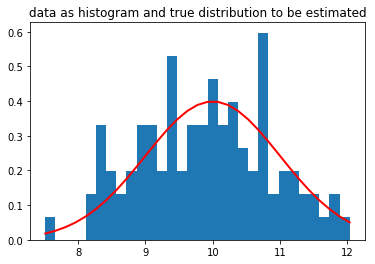

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', 
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

In [4]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1, 1], model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

Successful execution of the MCMC design


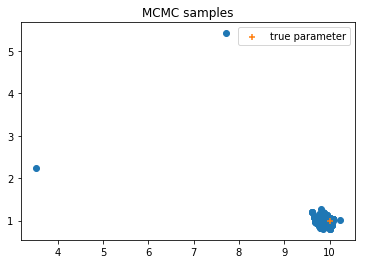

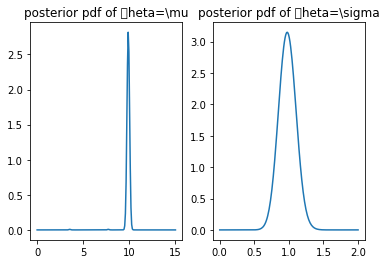

In [5]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of \theta=\mu')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of \theta=\sigma')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[ -1.42098989  -0.4858734    2.07589578   2.66224561   3.3555957
   5.52469831   3.98678665   6.32850348   7.28279652   8.91905681
  12.41415336  12.52209359  14.19324331  16.59033321  18.80980464
  21.08834764  25.02010735  27.84092492  31.29818548  33.5438917
  38.09119194  42.62581002  44.65745313  48.48736971  52.2699155
  58.2745567   62.76761265  67.21202117  69.99575029  75.6518847
  79.18275156  85.92419351  92.12788808  98.54010524 101.91538421
 108.94246307 115.61269939 119.93746354 128.95399779 135.36789117
 142.98000493 149.43398461 156.22814105 162.02928846 169.92116557
 179.78429004 186.03664457 194.20883647 201.12196909 211.52113224]


In [7]:
candidate_model = Model(n_params=2, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic',
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'MCMC', nsamples=500,
                                           algorithm = 'MH', jump=10, nburn=0, pdf_proposal = 'Normal',
                                           pdf_proposal_scale = [0.1, 0.05], seed = [0.5, 2.5])

Successful execution of the MCMC design


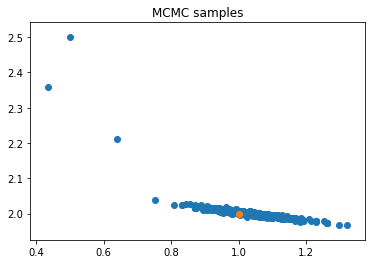

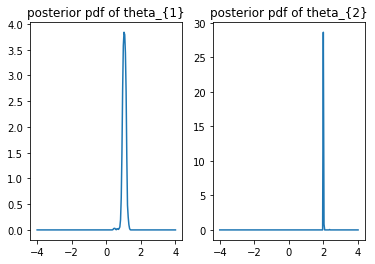

In [9]:
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

Acceptance ratio of the chain = 0.0678135627125425
Multivariate ESS = 3037.50251457821, minESS = 7529.096402175249
Univariate ESS in each dimension
Parameter 1: ESS = 1976.907090471152, minESS = 6146.334113110603
Parameter 2: ESS = 3247.2197155699273, minESS = 6146.334113110603


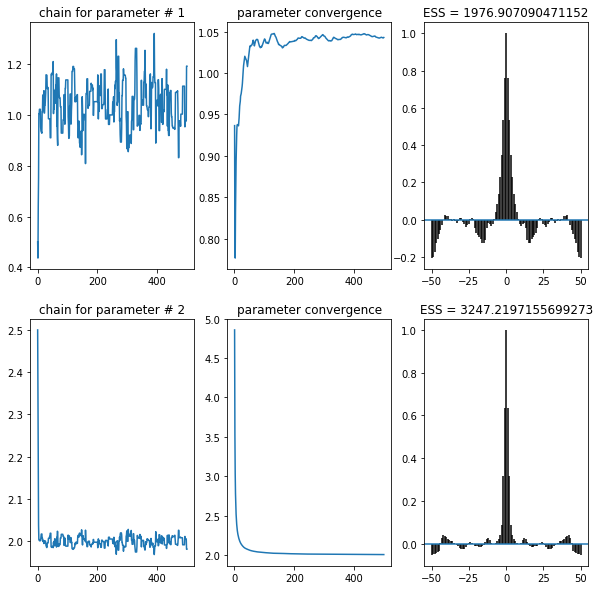

In [10]:
Diagnostics(sampling_method='MCMC', sampling_outputs = bayes_estimator)